# Explore data
To see how we can use our data, we do some investigation.

In [6]:
# Load libraries
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from yellowbrick.regressor import ResidualsPlot, PredictionError

In [10]:
# Load pickle file
df = pd.read_pickle("../data/combination.pkl")

In [3]:
df.shape

(8030, 474)

In [4]:
# Check for null values
[col for col, val in df.isnull().any().items() if val]

[]

In [9]:
# Temp solution
df.rename(columns={"rf_plat dak": "rf_plat_dak"}, 
          inplace=True)
df.drop(df[df['asking_price'] == 0].index, inplace=True)
df.drop(df[(df.asking_price > 10000000) 
           | (df.asking_price < 100000)]
        .index, inplace=True)

In [8]:
no_ne = [col for col in df.columns if not col.startswith("ne")]
no_ne

['address',
 'asking_price',
 'price_m2',
 'days_online',
 'service_fees_pm',
 'vve_contribution',
 'build_year',
 'land_m2',
 'property_m3',
 'living_m2',
 'floors',
 'apartment_level',
 'garden',
 'balcony',
 'storage_type',
 'parking',
 'vve_kvk',
 'vve_am',
 'vve_per_contr',
 'vve_reserve_fund',
 'vve_maintenance',
 'vve_insurance',
 'num_bathrooms',
 'num_toilets',
 'rooms',
 'bedrooms',
 'pt_split-level_woning',
 'pt_dubbel_benedenhuis',
 'pt_bungalow',
 'pt_dubbel_bovenhuis',
 'pt_corridorflat',
 'pt_herenhuis',
 'pt_tussenwoning',
 'pt_portiekwoning',
 'pt_drive-in_woning',
 'pt_open_portiek',
 'pt_beneden_+_bovenwoning',
 'pt_halfvrijstaande_woning',
 'pt_eengezinswoning',
 'pt_geschakelde_2-onder-1-kapwoning',
 'pt_bedrijfs-_of_dienstwoning',
 'pt_hoekwoning',
 'pt_appartement',
 'pt_bovenwoning',
 'pt_villa',
 'pt_service_flat',
 'pt_waterwoning',
 'pt_penthouse',
 'pt_2-onder-1-kapwoning',
 'pt_geschakelde_woning',
 'pt_appartement_met_open_portiek',
 'pt_kwadrant_woning',


In [11]:
# Use a subset without neighborhoods for correlation check
subset = df[no_ne]

## Correlation check
Initially we want to know what factors have a big influence on the asking price.

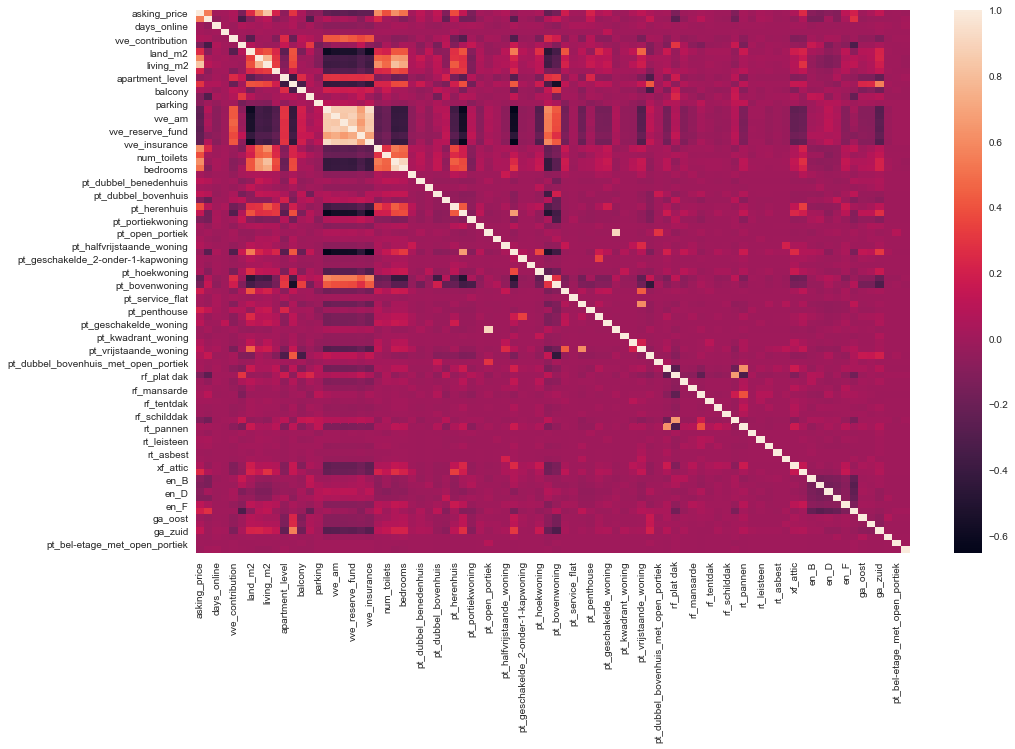

In [13]:
# Produce a heatmap 
fig, ax = plt.subplots(figsize=(16,10))
corr = subset.corr()
sns.heatmap(corr)

There seems to be high correlation between the various columns:
- VVE columns
- property_m3 vs living_m2
- appartement_met_open_portiek vs open_portiek
- price_m2
so we can drop a few of them.

It appears something went wrong with the attic column so we drop that, too.

In [39]:
# Drop columns
vve = [col 
       for col in df.columns 
       if col.startswith("vve") 
       and col not in ["vve_contribution", "vve_maintenance"]]
others = ["rt_pannen", "rf_plat_dak", 
          "pt_appartement_met_open_portiek", "address", "price_m2"]

df = df.drop(columns=vve + others)

For some reason the model doesn't work when we remove all these columns, so only address and price_m2 are removed. 

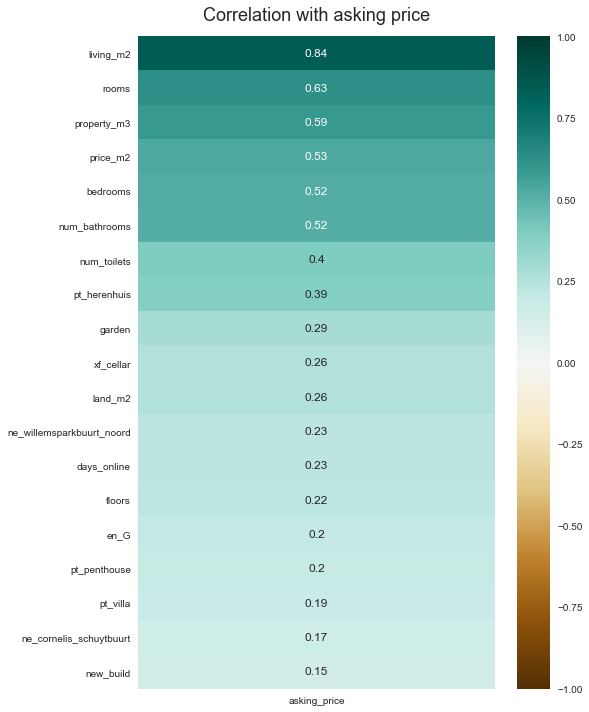

In [8]:
# Correlation viewed related to asking price
corr_series = (df.corr()[["asking_price"]]
               .sort_values(by="asking_price", ascending=False))

plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(corr_series[1:20], 
                      vmin=-1, 
                      vmax=1, 
                      annot=True, 
                      cmap='BrBG')
heatmap.set_title("Correlation with asking price", 
                  fontdict={'fontsize':18}, 
                  pad=16);

## Preprocessing

In [87]:
# Select column names of factors with more than 2 values
num_cols = [col for col in df.columns 
            if df[col].nunique() > 2 
            and df[col].dtype in ["int64", "float64"] 
            and col != "asking_price"]

### Outliers

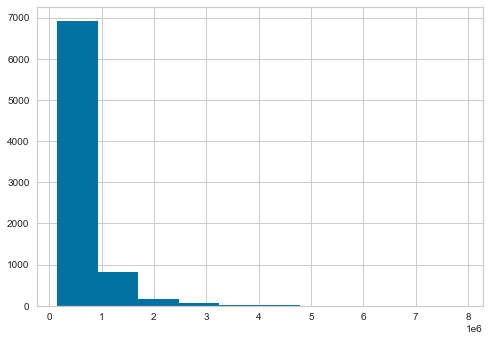

In [7]:
#df[(df.asking_price > 10000000) | (df.asking_price < 100000)]
df.asking_price.hist()

In [269]:
apartments = ["pt_bovenwoning", "pt_benedenwoning", "pt_penthouse",
                  "pt_corridorflat", "pt_portiekwoning"]
a = df[df[apartments].apply(any, axis=1)].copy()
h = df[~df[apartments].apply(any, axis=1)].copy()
a

,address,asking_price,price_m2,days_online,service_fees_pm,vve_contribution,new_build,build_year,land_m2,property_m3,...,ne_landelijk_gebied_driemond,ne_leidsebuurt_zuidwest,ne_nieuwendammerdijk_oost,ne_osdorp_midden_noord,ne_planciusbuurt_noord,ne_vondelpark_oost,ne_vu-kwartier,ne_woon-_en_groengebied_sloterdijk,ne_zeeburgereiland_zuidwest,ne_zuidas_noord
30,"Eksterstraat 49, 1021 EB, Amsterdam",375000,4747,3.0,0,136.00,0,1918,0,261,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,"Hestiastraat 63, 1076 DK, Amsterdam",950000,6884,3.0,0,137.00,0,1928,0,461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,"Willem de Zwijgerlaan 146, 1056 JV, Amsterdam",260000,6341,3.0,87,87.00,0,1937,0,139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34,"Bankastraat 61, 1094 EC, Amsterdam",300000,7317,2.0,0,105.77,0,1912,0,137,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,"Haarlemmerdijk 107, 1013 KD, Amsterdam",585000,6964,3.0,66,65.80,0,1906,0,257,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8042,"Cornelis Trooststraat 75, 1072 JD, Amsterdam",400000,6897,0.0,0,75.00,0,1905,0,293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8043,"Haparandaweg 692, 1013 BD, Amsterdam",660000,6346,0.0,0,170.00,0,2014,0,337,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8044,"Orteliusstraat 293, 1056 NX, Amsterdam",599000,6885,0.0,90,90.00,0,1927,0,270,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8045,"Wijsmullerstraat 34, 1058 JK, Amsterdam",425000,7456,0.0,0,102.22,0,1932,0,189,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [270]:
h_drop = ["apartment_level"]

h[["asking_price"]+num_cols].describe()

,asking_price,price_m2,days_online,service_fees_pm,vve_contribution,build_year,land_m2,property_m3,living_m2,floors,apartment_level,num_bathrooms,num_toilets,rooms,bedrooms
count,1.380000e+03,1380.000000,1380.000000,1.380000e+03,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000
mean,9.088243e+05,5656.347101,35.515217,1.170186e+03,12.375297,1955.818116,124.968116,455.953623,150.962319,2.781884,0.085507,1.330435,1.144203,5.395652,3.660145
std,8.134087e+05,2165.070222,60.480219,4.046604e+04,47.738360,72.849032,125.883709,191.747298,79.680089,0.978873,0.287408,0.867311,0.789848,2.058600,1.358135
min,2.100000e+05,1400.000000,0.000000,0.000000e+00,0.000000,1005.000000,0.000000,0.000000,37.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,4.493750e+05,4054.000000,0.000000,0.000000e+00,0.000000,1923.000000,45.000000,327.750000,103.750000,2.000000,0.000000,1.000000,1.000000,4.000000,3.000000
50%,6.500000e+05,5057.000000,0.000000,0.000000e+00,0.000000,1972.000000,111.000000,430.000000,131.000000,3.000000,0.000000,1.000000,1.000000,5.000000,4.000000
75%,9.950000e+05,6838.000000,42.000000,0.000000e+00,0.000000,2003.000000,151.000000,562.000000,171.000000,3.000000,0.000000,2.000000,1.000000,6.000000,4.000000
max,7.500000e+06,16995.000000,240.000000,1.500000e+06,471.000000,2021.000000,998.000000,999.000000,723.000000,7.000000,2.000000,7.000000,5.000000,24.000000,15.000000


In [271]:
h["asking_price"].max()-h["asking_price"].min()

7290000

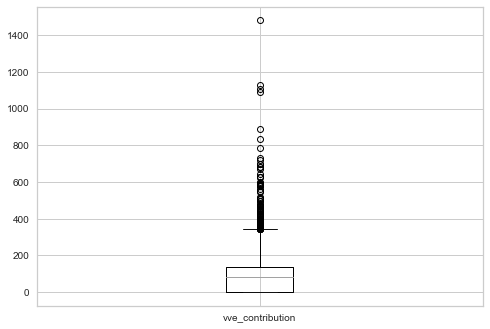

In [153]:
h.boxplot("vve_contribution")

## Split data

In [88]:
# Set variables
# X = df[[col for col in df.columns if col != "asking_price"]]
# "pt_appartement_met_open_portiek", , "price_m2"
to_drop = ["asking_price", "address"]
X = df[[col for col in df.columns if col not in to_drop ]]
y = df["asking_price"]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=7)

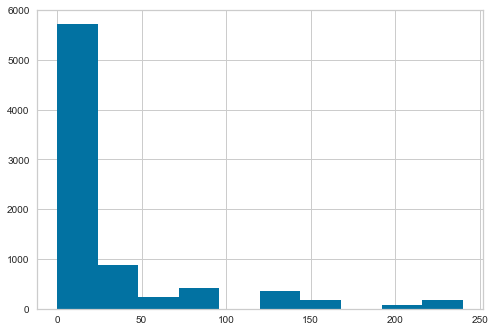

In [41]:
df["days_online"].hist()

In [22]:
df.reset_index(drop=True, inplace=True)

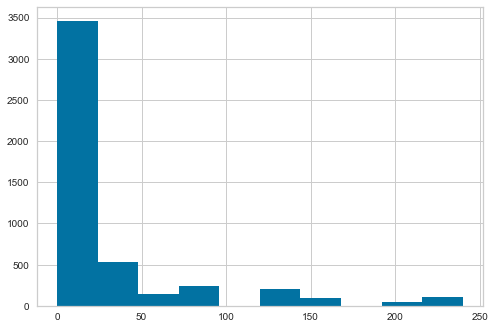

In [89]:
# Fit scaler model 
std = StandardScaler()
scaled_fit = std.fit(X_train[num_cols])

# Apply to dataframe
for xf in [X_train, X_test]:
    xf.reset_index(drop=True, inplace=True)
    scaled = pd.DataFrame(scaled_fit.transform(xf[num_cols]), 
                                columns=num_cols)
    xf = xf.drop(columns=num_cols, axis=1)
    xf = xf.merge(scaled, left_index=True, right_index=True, how="outer")

X_train["days_online"].hist()

## Linear regression
Now we train a model to check for linear regression.

In [90]:
# Instantiate the class
lin_model = linear_model.LinearRegression()
# Create the model
lin_model.fit(X_train, y_train)
score = lin_model.score(X_train, y_train)
print(f"R2: {score:.5f}")

R2: 0.94580


Our initial score (0.70) is not very high. This could have various reasons. Most obvious is the way we selected our features. 
Edit: By adding living_m2 and scaling after the split we achieved much better values.

In [25]:
def visualize_model(plot, model, train, test):
    visualizer = plot(model)
    visualizer.fit(*train)
    visualizer.score(*test)
    visualizer.show() 

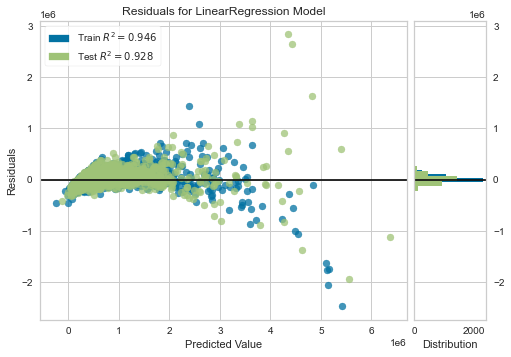

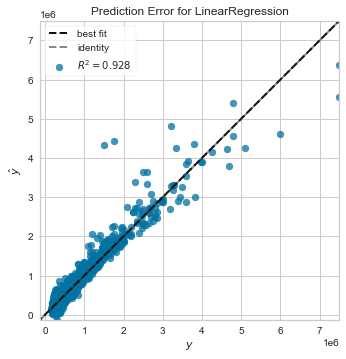

In [84]:
#fig, axes = plt.subplots(2, 1, figsize=(16,10))
for i, plot in enumerate([ResidualsPlot, PredictionError]):
    visualize_model(plot, lin_model, (X_train, y_train), (X_test, y_test))

#### Interpretation
The points are not randomly dispersed around the horizontal axis,  which means that a linear regression model is probably not appropriate for the data and we should use a non-linear model. The R<sup>2</sup> for the training set is very good, however the R<sup>2</sup> for the test set is average, which also shows in the fact that the train data (green) is normally distributed around 0, but not the test data.

# Externalize in full func
To be able to run the full thing in one go, we save the whole thing in a external script.

In [5]:
import importllib

    from ..predict_price import lookup_worth

ImportError: attempted relative import with no known parent package